## 实验八：全流程垃圾分类应用（Part I）
本实验的目的是熟悉图片分类从训练到部署的全流程应用，熟悉和使用ModelArts平台和MindSpore深度学习框架，掌握移植和优化代表性图片分类算法（SENet）的方法和流程，基于垃圾分类数据集实现图片分类算法的训练、验证、推理和部署。

### 1. 实验目标

* 基于Modelarts平台，使用MindSpore框架构建图片分类网络，在垃圾分类训练数据集上完成模型训练，并保存对应的模型权重。

* 基于Modelarts平台，使用MindSpore框架导入训练好的图片分类网络，在垃圾分类测试数据集上完成模型验证和推理。

* 使用AscendCL实现模型应用的部署开发，搭建一个实时的图片分类应用。

### 2. 背景介绍
### 2.1 SEResNet网络介绍
SENet（Squeeze-and-Excitation Networks ）是 ImageNet 2017 竞赛 Image Classification 任务的冠军。在ImageNet数据集上将top-5 错误率降低到2.251%，原先的最好成绩是2.991%。SENet网络创新点在于关注通道之间的关系，希望模型可以自动学习到不同通道特征的重要程度，也就是如下图所示的Squeeze-and-Excitation Module。\
SE模块首先对卷积得到的特征图进行Squeeze操作，得到channel的全局特征，然后对全局特征进行Excitation操作，学习各个channel之间的关系，也得到不同的channel的权重，最后乘以原来的特征图得到加权特征。本质上，SE模块是channel维度上做attention或者gating操作，使模型可以更加关注更具有表征能力的通道特征，抑制那些不重要的通道特征。\
SE模块的灵活性在于它可以直接应用现有的网络结构中。对于ResNet，SE模块嵌入到残差结构中的残差学习分支中。具体如下图所示：

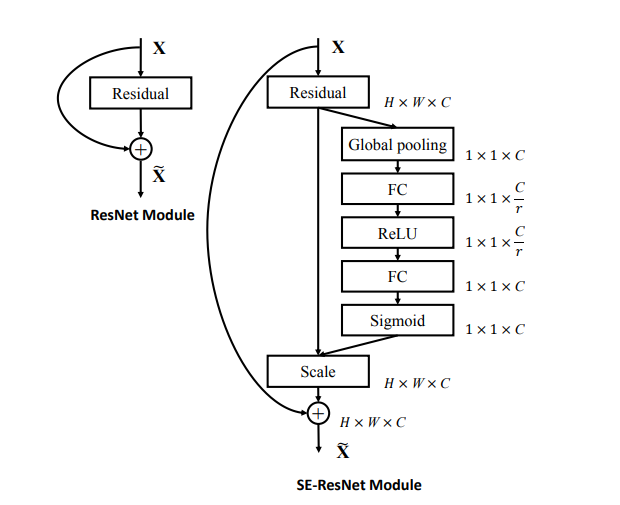

此实验使用SEResNet-50网络实现垃圾分类应用，具体网络结构如下所示：

| Input Size |                         SE-ResNet-50                         | Output Size |
| :--------: | :----------------------------------------------------------: | :---------: |
| 3×224×224  |   [conv, 7 × 7, 64, stride 2], [max pool, 3 × 3, stride 2]   | 64x112×112  |
| 64x112×112 | [[conv, 1×1, 64], [conv, 3×3, 64], [conv, 1×1, 256] [fc, 16, 256] × 3 |  256x56×56  |
| 256x56×56  | [[conv, 1×1, 128], [conv, 3×3, 128], [conv, 1×1, 512] [fc, 32, 512] × 4 |  512x28×28  |
| 512x28×28  | [[conv, 1×1, 256], [conv, 3×3, 256], [conv, 1×1, 1024] [fc, 64, 1024] × 6 | 1024x14×14  |
| 1024x14×14 | [[conv, 1×1, 512], [conv, 3×3, 512], [conv, 1×1, 2048] [fc, 128, 2048] × 3 |   20487×7   |
|  2048x7×7  |                     global average pool                      |    2048     |
|    2048    |                       40-d fc, softmax                       |     40      |

### 3. 实验环境

- 环境要求
支持Ascend

- 环境准备

| 依赖   | 版本   |
| ------ | ------ |
| c++    | 7.5.0  |
| cmake  | 3.10.2 |
| python | 3.7.5  |
| mindspore | 2.0  |

### 4. 数据处理
### 4.1 数据准备

请点击数据集链接，下载以下数据集，下载的exp8_garbage.zip解压，解压出 train,test,val 文件夹，和notebook同步目录：


目录结构如下：

./ \
|── data \
|&emsp;&emsp;&emsp;|── train \
|&emsp;&emsp;&emsp;|── test \
|&emsp;&emsp;&emsp;|── val \
|&emsp;&emsp;&emsp;|── label_list.json


下载链接如下：\
https://openi.pcl.ac.cn/attachments/449d1886-cf6f-4400-bef2-c1fef422652c?type=1

### 4.2 数据加载模块
我们定义一个函数create_dataset来创建数据集。在这个函数中，我们定义好需要进行的数据增强和处理操作：
- 读取数据集。
- 定义进行数据增强和处理所需要的一些参数。
- 根据参数，生成对应的数据增强操作。

代码实现如下：

In [1]:
def resnet_create_dataset(data_home, image_size, batch_size, rank_id=0, rank_size=1, training=True,valid=False):
    """Data operations."""
    data_dir = data_home
    data_dir = os.path.join(data_home, "train")
    if not training:
        data_dir = os.path.join(data_home, "test")
    if valid:
        data_dir = os.path.join(data_home, "val")
    label_list={}
    for i in range(40):
        label_list[str(i)]=i
    data_set = de.ImageFolderDataset(data_dir,
                                     class_indexing=label_list,
                                     shuffle=False, num_shards=rank_size, shard_id=rank_id)

    transform_img = vision.RandomCropDecodeResize([288,288], scale=(0.08, 1.0),
                                              ratio=(0.75, 1.333))  # 改变尺寸
    rescale = 1.0 / 255.0
    shift = 0.0
    changeswap_op = vision.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.float32)
    resize_op = vision.Resize(image_size)  # interpolation default BILINEAR
    rescale_op = vision.Rescale(rescale, shift)
    random_horizontal_op = vision.RandomHorizontalFlip()
    normalize_op =  vision.Normalize((0.4465, 0.4822, 0.4914), (0.2010, 0.1994, 0.2023))

    # apply map operations on images
     #data_set = data_set.map(operations=type_cast_op, input_columns="label")
    if training:
        data_set = data_set.map(input_columns="image", operations=transform_img)
        data_set = data_set.map(input_columns="image", operations=random_horizontal_op)
    else:
        decode_op = vision.Decode()
        data_set = data_set.map(input_columns="image", operations=decode_op)
        data_set = data_set.map(input_columns="image", operations=resize_op)

    data_set = data_set.map(input_columns="image", operations=normalize_op)
    data_set = data_set.map(input_columns="image", operations=type_cast_op)
    data_set = data_set.map(input_columns="image", operations=changeswap_op)

    # apply shuffle operations
    data_set = data_set.shuffle(buffer_size=data_set.get_dataset_size())
    
    # apply batch operations
    data_set = data_set.batch(batch_size=batch_size, drop_remainder=True)
    
    return data_set



### 4.3 数据集分析

我们示例中用到的垃圾分类数据集，总共包括40种垃圾类型，如下可视化出数据的分布：

In [2]:
import os
import numpy as np
import random
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

def draw_data_count(image_dir, dtype="bar"):
    sub_folders = next(os.walk(image_dir))[1]
    sub_folders.sort(key=lambda x:int(x))
    sub_folders_info = []
    all_image_nums = 0
    for sub_folder in tqdm(sub_folders):
        image_ids = next(os.walk(os.path.join(image_dir, sub_folder)))[2]
        image_ids = [i for i in image_ids]
        image_counts = len(image_ids)
        sub_folders_info.append((sub_folder, image_counts))
        all_image_nums += image_counts
    
    x = [i[0] for i in sub_folders_info]
    y = [i[1] for i in sub_folders_info]
    plt.figure(figsize=(16, 8))
    
    if dtype == "bar":
        plt.bar(x, y, width=0.8)
        for i,j in enumerate(y):
            plt.text(i, j+4, j,ha='center',fontsize=8)
    elif dtype == "pie":
        plt.pie(y, labels=x)
        plt.axis('equal')
    else:
        raise ValueError
        
def draw_data_size(image_dir):
    sub_folders = next(os.walk(image_dir))[1]
    sub_folders.sort(key=lambda x:int(x))
    data_size_list = []
    for sub_folder in tqdm(sub_folders):
        image_ids = next(os.walk(os.path.join(image_dir, sub_folder)))[2]
        # 这里随机取样十分之一样本统计尺寸大小
        random.shuffle(image_ids)
        image_shapes = [cv2.imread(os.path.join(image_dir, sub_folder, image_ids[i])).shape[:2] for i in range(len(image_ids)//10)]
        data_size_list.extend(image_shapes)
    
    h = [i[0] for i in data_size_list]
    w = [i[1] for i in data_size_list]
    plt.figure(figsize=(16, 8))
    
    plt.scatter(h, w)

100%|██████████| 40/40 [00:00<00:00, 1093.35it/s]


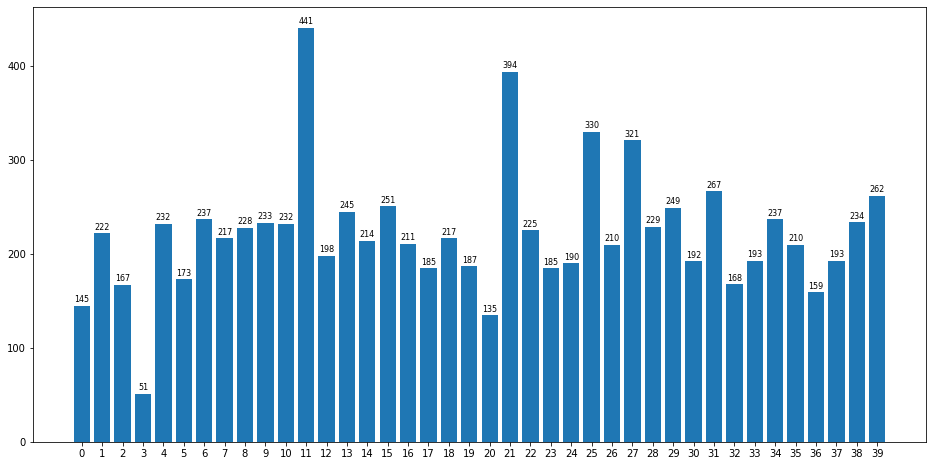

In [3]:
# 统计训练集每个类别的数量
draw_data_count("../data/train/", dtype="bar")
# plt.|savefig("train_count.png")

100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


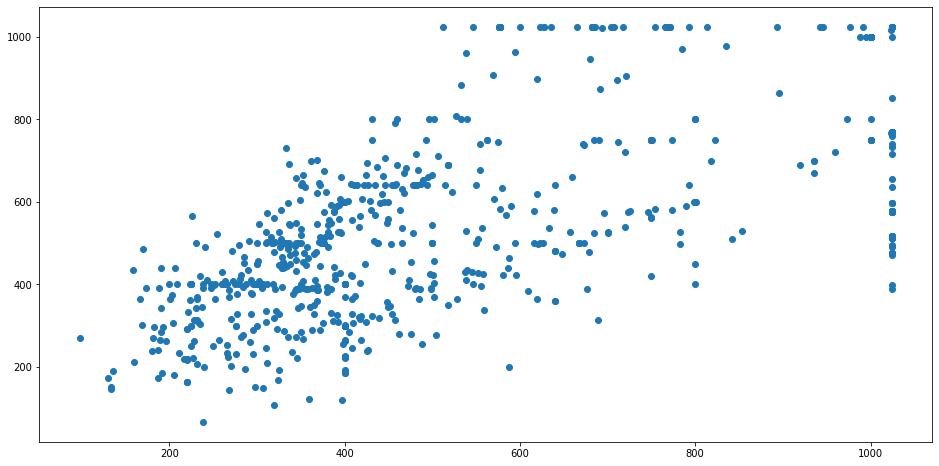

In [4]:
# 统计训练集尺寸大小分布
draw_data_size("../data/train/")
# plt.savefig("train_size.png")

100%|██████████| 40/40 [00:00<00:00, 2815.44it/s]


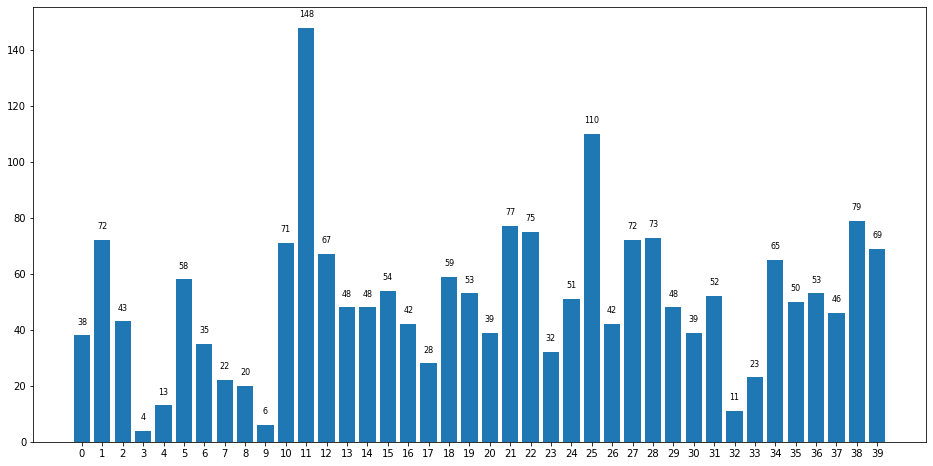

In [5]:
# 统计验证集每个类别的数量
draw_data_count("../data/val/", dtype="bar")

100%|██████████| 40/40 [00:00<00:00, 41.37it/s]


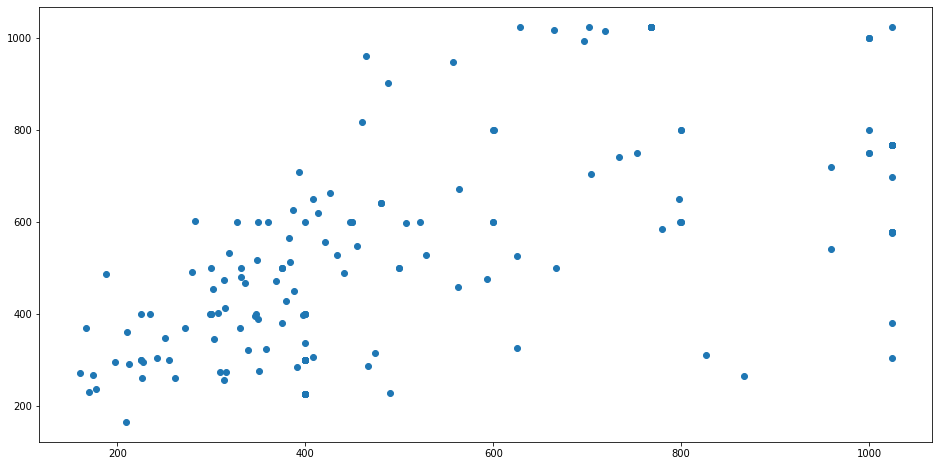

In [6]:
# 统计验证集尺寸大小分布
draw_data_size("../data/val/")

### 5. 实验内容

train函数代码如下：

In [7]:

def run_train():
    '''run train'''
    config.lr_epochs = list(map(int, config.lr_epochs.split(',')))
    config.image_size = list(map(int, config.image_size.split(',')))
    config.per_batch_size = config.batch_size

    _enable_graph_kernel = (config.device_target == "GPU")
    context.set_context(mode=context.PYNATIVE_MODE,
                        enable_graph_kernel=_enable_graph_kernel, device_target=config.device_target)
    config.rank = get_rank_id()
    config.device_id = get_device_id()
    config.group_size = get_device_num()

    if config.is_distributed:
        if config.device_target == "Ascend":
            init()
            context.set_context(device_id=config.device_id)
        elif config.device_target == "GPU":
            if not config.enable_modelarts:
                init()
            else:
                if not config.need_modelarts_dataset_unzip:
                    init()

        device_num = config.group_size
        context.reset_auto_parallel_context()
        context.set_auto_parallel_context(device_num=device_num, parallel_mode=ParallelMode.DATA_PARALLEL,
                                          gradients_mean=True, all_reduce_fusion_config=[15, 18])
    else:
        if context.get_context("device_id") == config.device_id:
            pass
        else:
            context.set_context(device_id=config.device_id)

    # select for master rank save ckpt or all rank save, compatible for model parallel
    config.rank_save_ckpt_flag = 0
    if config.is_save_on_master:
        if config.rank == 0:
            config.rank_save_ckpt_flag = 1
    else:
        config.rank_save_ckpt_flag = 1

    # logger
    config.outputs_dir = os.path.join(config.ckpt_path,
                                      datetime.datetime.now().strftime('%Y-%m-%d_time_%H_%M_%S'))
    config.logger = get_logger(config.outputs_dir, config.rank)

    if config.dataset == "garbage_photos":
        dataset = resnet_create_dataset(config.data_dir, config.image_size, config.per_batch_size,
                                     config.rank, config.group_size)
        val_dataset = resnet_create_dataset(config.data_dir, config.image_size,config.per_batch_size,config.rank, config.group_size,valid=True)

    batch_num = dataset.get_dataset_size()
    config.steps_per_epoch = dataset.get_dataset_size()
    config.logger.save_args(config)

    # network
    config.logger.important_info('start create network')
 

    net = se_resnet50(40)
   
    
    
    # pre_trained
    if config.pre_trained:
        load_param_into_net(net, load_checkpoint(config.pre_trained))

    # lr scheduler
    if config.lr_scheduler == 'exponential':
        lr = warmup_step_lr(config.lr,
                            config.lr_epochs,
                            config.steps_per_epoch,
                            config.warmup_epochs,
                            config.max_epoch,
                            gamma=config.lr_gamma,
                            )
    elif config.lr_scheduler == 'cosine_annealing':
        lr = warmup_cosine_annealing_lr(config.lr,
                                        config.steps_per_epoch,
                                        config.warmup_epochs,
                                        config.max_epoch,
                                        config.T_max,
                                        config.eta_min)
    elif config.lr_scheduler == 'step':
        lr = lr_steps(0, lr_init=config.lr_init, lr_max=config.lr_max, warmup_epochs=config.warmup_epochs,
                      total_epochs=config.max_epoch, steps_per_epoch=batch_num)
    elif config.lr_scheduler == 'custom':
        lr = get_lr(lr_init=config.lr_init, lr_end=config.lr_end, lr_max=config.lr_max,
                    warmup_epochs=config.warmup_epochs,total_epochs=config.max_epoch, steps_per_epoch=batch_num,
                    lr_decay_mode=config.lr_decay_mode)
            
    else:
        raise NotImplementedError(config.lr_scheduler)

   # optimizer
    opt = Momentum(params=get_param_groups(net),
                   learning_rate=Tensor(lr),
                   momentum=config.momentum,
                   weight_decay=config.weight_decay,
                   loss_scale=config.loss_scale)
    
    # opt = nn.SGD(params=get_param_groups(network), 
    #              learning_rate=Tensor(lr),
    #              momentum=config.momentum,
    #              weight_decay=config.weight_decay,
    #              loss_scale=config.loss_scale)
    
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    model = Model(net, loss_fn=loss, optimizer=opt, metrics={"Accuracy": Accuracy()},
                    amp_level="O2", keep_batchnorm_fp32=False, loss_scale_manager=None)
   
    
    # 定义回调函数
    time_cb = TimeMonitor(data_size=batch_num)
    loss_cb = LossMonitor(batch_num)
    epoch_per_eval = {"epoch": [], "acc": []}
    callbacks = [time_cb, loss_cb]
    if config.rank_save_ckpt_flag:
        ckpt_config = CheckpointConfig(save_checkpoint_steps=config.ckpt_interval * config.steps_per_epoch,
                                       keep_checkpoint_max=config.keep_checkpoint_max)
        save_ckpt_path = os.path.join(config.outputs_dir, 'ckpt_' + str(config.rank) + '/')
        print(save_ckpt_path)
        ckpt_cb = ModelCheckpoint(config=ckpt_config,
                                  directory=save_ckpt_path,
                                  prefix='{}'.format(config.rank))
        callbacks.append(ckpt_cb)
    
    #进行模型训练
    model.train(config.max_epoch, dataset, callbacks=callbacks)

### 6. 模型构建

利用MindSpore相关API完整搭建se_resnet网络结构。在利用MindSpore构建网络时，需要继承 mindspore.nn.Cell 类，并重写 _init_ 方法和construct方法。

In [8]:
import math
import numpy as np
from scipy.stats import truncnorm
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import dtype as mstype
from mindspore import Tensor


def conv_variance_scaling_initializer(in_channel, out_channel, kernel_size):
    fan_in = in_channel * kernel_size * kernel_size
    scale = 1.0
    scale /= max(1., fan_in)
    stddev = (scale ** 0.5) / .87962566103423978

    mu, sigma = 0, stddev
    weight = truncnorm(-2, 2, loc=mu, scale=sigma).rvs(out_channel * in_channel * kernel_size * kernel_size)
    weight = np.reshape(weight, (out_channel, in_channel, kernel_size, kernel_size))
    return Tensor(weight, dtype=mstype.float32)


def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)


def calculate_gain(nonlinearity, param=None):
    """calculate_gain"""
    linear_fns = ['linear', 'conv1d', 'conv2d', 'conv3d', 'conv_transpose1d', 'conv_transpose2d', 'conv_transpose3d']
    res = 0
    if nonlinearity in linear_fns or nonlinearity == 'sigmoid':
        res = 1
    elif nonlinearity == 'tanh':
        res = 5.0 / 3
    elif nonlinearity == 'relu':
        res = math.sqrt(2.0)
    elif nonlinearity == 'leaky_relu':
        if param is None:
            neg_slope = 0.01
        elif not isinstance(param, bool) and isinstance(param, int) or isinstance(param, float):
            neg_slope = param
        else:
            raise ValueError("neg_slope {} not a valid number".format(param))
        res = math.sqrt(2.0 / (1 + neg_slope ** 2))
    else:
        raise ValueError("Unsupported nonlinearity {}".format(nonlinearity))
    return res


def _calculate_fan_in_and_fan_out(tensor):
    """_calculate_fan_in_and_fan_out"""
    dimensions = len(tensor)
    if dimensions < 2:
        raise ValueError("Fan in and fan out can not be computed for tensor with fewer than 2 dimensions")
    if dimensions == 2:  # Linear
        fan_in = tensor[1]
        fan_out = tensor[0]
    else:
        num_input_fmaps = tensor[1]
        num_output_fmaps = tensor[0]
        receptive_field_size = 1
        if dimensions > 2:
            receptive_field_size = tensor[2] * tensor[3]
        fan_in = num_input_fmaps * receptive_field_size
        fan_out = num_output_fmaps * receptive_field_size
    return fan_in, fan_out


def _calculate_correct_fan(tensor, mode):
    mode = mode.lower()
    valid_modes = ['fan_in', 'fan_out']
    if mode not in valid_modes:
        raise ValueError("Unsupported mode {}, please use one of {}".format(mode, valid_modes))
    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    return fan_in if mode == 'fan_in' else fan_out


def kaiming_normal(inputs_shape, a=0, mode='fan_in', nonlinearity='leaky_relu'):
    fan = _calculate_correct_fan(inputs_shape, mode)
    gain = calculate_gain(nonlinearity, a)
    std = gain / math.sqrt(fan)
    return np.random.normal(0, std, size=inputs_shape).astype(np.float32)


def kaiming_uniform(inputs_shape, a=0., mode='fan_in', nonlinearity='leaky_relu'):
    fan = _calculate_correct_fan(inputs_shape, mode)
    gain = calculate_gain(nonlinearity, a)
    std = gain / math.sqrt(fan)
    bound = math.sqrt(3.0) * std  # Calculate uniform bounds from standard deviation
    return np.random.uniform(-bound, bound, size=inputs_shape).astype(np.float32)


def _conv3x3(in_channel, out_channel, stride=1, use_se=False, res_base=False):
    if use_se:
        weight = conv_variance_scaling_initializer(in_channel, out_channel, kernel_size=3)
    else:
        weight_shape = (out_channel, in_channel, 3, 3)
        weight = Tensor(kaiming_normal(weight_shape, mode="fan_out", nonlinearity='relu'))
    if res_base:
        return nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride,
                         padding=1, pad_mode='pad', weight_init=weight)
    return nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride,
                     padding=0, pad_mode='same', weight_init=weight)


def _conv1x1(in_channel, out_channel, stride=1, use_se=False, res_base=False):
    if use_se:
        weight = conv_variance_scaling_initializer(in_channel, out_channel, kernel_size=1)
    else:
        weight_shape = (out_channel, in_channel, 1, 1)
        weight = Tensor(kaiming_normal(weight_shape, mode="fan_out", nonlinearity='relu'))

    if res_base:
        return nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride,
                         padding=0, pad_mode='pad', weight_init=weight)
    return nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride,
                     padding=0, pad_mode='same', weight_init=weight)


def _conv7x7(in_channel, out_channel, stride=1, use_se=False, res_base=False):
    if use_se:
        weight = conv_variance_scaling_initializer(in_channel, out_channel, kernel_size=7)
    else:
        weight_shape = (out_channel, in_channel, 7, 7)
        weight = Tensor(kaiming_normal(weight_shape, mode="fan_out", nonlinearity='relu'))

    if res_base:
        return nn.Conv2d(in_channel, out_channel,
                         kernel_size=7, stride=stride, padding=3, pad_mode='pad', weight_init=weight)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _bn(channel, res_base=False):
    if res_base:
        return nn.BatchNorm2d(channel, eps=1e-5, momentum=0.1,
                              gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)


def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)


def _fc(in_channel, out_channel, use_se=False):
    if use_se:
        weight = np.random.normal(loc=0, scale=0.01, size=out_channel * in_channel)
        weight = Tensor(np.reshape(weight, (out_channel, in_channel)), dtype=mstype.float32)
    else:
        weight_shape = (out_channel, in_channel)
        weight = Tensor(kaiming_uniform(weight_shape, a=math.sqrt(5)))

    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)


class ResidualBlock(nn.Cell):

    expansion = 4

    def __init__(self,
                 in_channel,
                 out_channel,
                 stride=1,
                 use_se=False, se_block=False):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.use_se = use_se
        self.se_block = se_block
        channel = out_channel // self.expansion
        self.conv1 = _conv1x1(in_channel, channel, stride=1, use_se=self.use_se)
        self.bn1 = _bn(channel)
        if self.use_se and self.stride != 1:
            self.e2 = nn.SequentialCell([_conv3x3(channel, channel, stride=1, use_se=True), _bn(channel),
                                         nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2, pad_mode='same')])
        else:
            self.conv2 = _conv3x3(channel, channel, stride=stride, use_se=self.use_se)
            self.bn2 = _bn(channel)

        self.conv3 = _conv1x1(channel, out_channel, stride=1, use_se=self.use_se)
        self.bn3 = _bn(out_channel)
       
        if self.se_block:
            self.se_global_pool = ops.ReduceMean(keep_dims=False)
            self.se_dense_0 = _fc(out_channel, int(out_channel / 4), use_se=self.use_se)
            self.se_dense_1 = _fc(int(out_channel / 4), out_channel, use_se=self.use_se)
            self.se_sigmoid = nn.Sigmoid()
            self.se_mul = ops.Mul()
        self.relu = nn.ReLU()

        self.down_sample = False

        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None

        if self.down_sample:
            if self.use_se:
                if stride == 1:
                    self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel,
                                                                         stride, use_se=self.use_se), _bn(out_channel)])
                else:
                    self.down_sample_layer = nn.SequentialCell([nn.MaxPool2d(kernel_size=2, stride=2, pad_mode='same'),
                                                                _conv1x1(in_channel, out_channel, 1,
                                                                         use_se=self.use_se), _bn(out_channel)])
            else:
                self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride,
                                                                     use_se=self.use_se), _bn(out_channel)])

    def construct(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        if self.use_se and self.stride != 1:
            out = self.e2(out)
        else:
            out = self.conv2(out)
            out = self.bn2(out)
            out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.se_block:
            out_se = out
            out = self.se_global_pool(out, (2, 3))
            out = self.se_dense_0(out)
            out = self.relu(out)
            out = self.se_dense_1(out)
            out = self.se_sigmoid(out)
            out = ops.reshape(out, ops.shape(out) + (1, 1))
            out = self.se_mul(out, out_se)

        if self.down_sample:
            identity = self.down_sample_layer(identity)

        out = out + identity
        out = self.relu(out)

        return out

class ResNet(nn.Cell):
    def __init__(self,
                 block,
                 layer_nums,
                 in_channels,
                 out_channels,
                 strides,
                 num_classes,
                 use_se=False,
                 res_base=False):
        super(ResNet, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")
        self.use_se = use_se
        self.res_base = res_base
        self.se_block = False
        if self.use_se:
            self.se_block = True

        if self.use_se:
            self.conv1_0 = _conv3x3(3, 32, stride=2, use_se=self.use_se)
            self.bn1_0 = _bn(32)
            self.conv1_1 = _conv3x3(32, 32, stride=1, use_se=self.use_se)
            self.bn1_1 = _bn(32)
            self.conv1_2 = _conv3x3(32, 64, stride=1, use_se=self.use_se)
        else:
            self.conv1 = _conv7x7(3, 64, stride=2, res_base=self.res_base)
        self.bn1 = _bn(64, self.res_base)
        self.relu = ops.ReLU()

        if self.res_base:
            self.pad = nn.Pad(paddings=((0, 0), (0, 0), (1, 1), (1, 1)))
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="valid")
        else:
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=strides[0],
                                       use_se=self.use_se)
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=strides[1],
                                       use_se=self.use_se)
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=strides[2],
                                       use_se=self.use_se,
                                       se_block=self.se_block)
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=strides[3],
                                       use_se=self.use_se,
                                       se_block=self.se_block)

        self.mean = ops.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.end_point = _fc(out_channels[3], num_classes, use_se=self.use_se)

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride, use_se=False, se_block=False):
   
        layers = []

        resnet_block = block(in_channel, out_channel, stride=stride, use_se=use_se)
        layers.append(resnet_block)
        if se_block:
            for _ in range(1, layer_num - 1):
                resnet_block = block(out_channel, out_channel, stride=1, use_se=use_se)
                layers.append(resnet_block)
            resnet_block = block(out_channel, out_channel, stride=1, use_se=use_se, se_block=se_block)
            layers.append(resnet_block)
        else:
            for _ in range(1, layer_num):
                resnet_block = block(out_channel, out_channel, stride=1, use_se=use_se)
                layers.append(resnet_block)
        return nn.SequentialCell(layers)

    def construct(self, x):
        if self.use_se:
            x = self.conv1_0(x)
            x = self.bn1_0(x)
            x = self.relu(x)
            x = self.conv1_1(x)
            x = self.bn1_1(x)
            x = self.relu(x)
            x = self.conv1_2(x)
        else:
            x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.res_base:
            x = self.pad(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        out = self.mean(c5, (2, 3))
        out = self.flatten(out)
        out = self.end_point(out)

        return out


def se_resnet50(class_num=1001,phase="train"):
 
    return ResNet(ResidualBlock,
                  [3, 4, 6, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num,
                  use_se=True)
 

In [9]:
### 7. 模型训练与验证

import datetime
import os
import time
import random
import numpy
import mindspore
import mindspore.nn as nn
from mindspore import Tensor
from mindspore import context
from mindspore.communication import init, get_rank, get_group_size
from mindspore.nn import Momentum
# from mindspore.nn.metrics import Accuracy
from mindspore.train import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor,Callback
from mindspore.train import Model
from mindspore import ParallelMode
from mindspore import load_param_into_net, load_checkpoint
from mindspore.amp import FixedLossScaleManager
from mindspore import set_seed
from src.dataset import resnet_create_dataset
from src.dataset import classification_dataset

from src.crossentropy import CrossEntropy
from src.warmup_step_lr import warmup_step_lr
from src.lr_generator import get_lr, warmup_cosine_annealing_lr
from src.warmup_step_lr import lr_steps
from src.utils.logging import get_logger
from src.utils.util import get_param_groups
from src.seresnet import se_resnet50

from model_utils.moxing_adapter import config
from model_utils.moxing_adapter import moxing_wrapper
from model_utils.device_adapter import get_device_id, get_rank_id, get_device_num


                  
def modelarts_pre_process():
    sum=1
    '''modelarts pre process function.'''
    def unzip(zip_file, save_dir):
        import zipfile
        s_time = time.time()
        if not os.path.exists(os.path.join(save_dir, config.modelarts_dataset_unzip_name)):
            zip_isexist = zipfile.is_zipfile(zip_file)
            if zip_isexist:
                fz = zipfile.ZipFile(zip_file, 'r')
                data_num = len(fz.namelist())
                print("Extract Start...")
                print("unzip file num: {}".format(data_num))
                data_print = int(data_num / 100) if data_num > 100 else 1
                i = 0
                for file in fz.namelist():
                    if i % data_print == 0:
                        print("unzip percent: {}%".format(int(i * 100 / data_num)), flush=True)
                    i += 1
                    fz.extract(file, save_dir)
                print("cost time: {}min:{}s.".format(int((time.time() - s_time) / 60),
                                                     int(int(time.time() - s_time) % 60)))
                print("Extract Done.")
            else:
                print("This is not zip.")
        else:
            print("Zip has been extracted.")

    if config.need_modelarts_dataset_unzip:
        zip_file_1 = os.path.join(config.data_path, config.modelarts_dataset_unzip_name + ".zip")
        save_dir_1 = os.path.join(config.data_path)

        sync_lock = "/tmp/unzip_sync.lock"

        # Each server contains 8 devices as most.
        if config.device_target == "GPU":
            init()
            device_id = get_rank()
            device_num = get_group_size()
        elif config.device_target == "Ascend":
            device_id = get_device_id()
            device_num = get_device_num()
        else:
            raise ValueError("Not support device_target.")

        if device_id % min(device_num, 8) == 0 and not os.path.exists(sync_lock):
            print("Zip file path: ", zip_file_1)
            print("Unzip file save dir: ", save_dir_1)
            unzip(zip_file_1, save_dir_1)
            print("===Finish extract data synchronization===")
            try:
                os.mknod(sync_lock)
            except IOError:
                pass

        while True:
            if os.path.exists(sync_lock):
                break
            time.sleep(1)

        print("Device: {}, Finish sync unzip data from {} to {}.".format(device_id, zip_file_1, save_dir_1))

    config.ckpt_path = os.path.join(config.output_path, config.ckpt_path)
 

@moxing_wrapper(pre_process=modelarts_pre_process)
def run_train():
    '''run train'''
    config.lr_epochs = list(map(int, config.lr_epochs.split(',')))
    config.image_size = list(map(int, config.image_size.split(',')))
    config.per_batch_size = config.batch_size

    _enable_graph_kernel = (config.device_target == "GPU")
    context.set_context(mode=context.PYNATIVE_MODE,
                        enable_graph_kernel=_enable_graph_kernel, device_target=config.device_target)
    config.rank = get_rank_id()
    config.device_id = get_device_id()
    config.group_size = get_device_num()

    if config.is_distributed:
        if config.device_target == "Ascend":
            init()
            context.set_context(device_id=config.device_id)
        elif config.device_target == "GPU":
            if not config.enable_modelarts:
                init()
            else:
                if not config.need_modelarts_dataset_unzip:
                    init()

        device_num = config.group_size
        context.reset_auto_parallel_context()
        context.set_auto_parallel_context(device_num=device_num, parallel_mode=ParallelMode.DATA_PARALLEL,
                                          gradients_mean=True, all_reduce_fusion_config=[15, 18])
    else:
        if context.get_context("device_id") == config.device_id:
            pass
        else:
            context.set_context(device_id=config.device_id)

    # select for master rank save ckpt or all rank save, compatible for model parallel
    config.rank_save_ckpt_flag = 0
    if config.is_save_on_master:
        if config.rank == 0:
            config.rank_save_ckpt_flag = 1
    else:
        config.rank_save_ckpt_flag = 1

    # logger
    config.outputs_dir = os.path.join(config.ckpt_path,
                                      datetime.datetime.now().strftime('%Y-%m-%d_time_%H_%M_%S'))
    config.logger = get_logger(config.outputs_dir, config.rank)

    if config.dataset == "garbage_photos":
        dataset = resnet_create_dataset(config.data_dir, config.image_size, config.per_batch_size,
                                     config.rank, config.group_size)
        val_dataset = resnet_create_dataset(config.data_dir, config.image_size,config.per_batch_size,config.rank, config.group_size,valid=True)

    batch_num = dataset.get_dataset_size()
    config.steps_per_epoch = dataset.get_dataset_size()
    config.logger.save_args(config)

    # network
    config.logger.important_info('start create network')
 
    net = se_resnet50(40)
   
    # pre_trained
    if config.pre_trained:
        load_param_into_net(net, load_checkpoint(config.pre_trained))

    # lr scheduler
    if config.lr_scheduler == 'exponential':
        lr = warmup_step_lr(config.lr,
                            config.lr_epochs,
                            config.steps_per_epoch,
                            config.warmup_epochs,
                            config.max_epoch,
                            gamma=config.lr_gamma,
                            )
    elif config.lr_scheduler == 'cosine_annealing':
        lr = warmup_cosine_annealing_lr(config.lr,
                                        config.steps_per_epoch,
                                        config.warmup_epochs,
                                        config.max_epoch,
                                        config.T_max,
                                        config.eta_min)
    elif config.lr_scheduler == 'step':
        lr = lr_steps(0, lr_init=config.lr_init, lr_max=config.lr_max, warmup_epochs=config.warmup_epochs,
                      total_epochs=config.max_epoch, steps_per_epoch=batch_num)
    elif config.lr_scheduler == 'custom':
        lr = get_lr(lr_init=config.lr_init, lr_end=config.lr_end, lr_max=config.lr_max,
                    warmup_epochs=config.warmup_epochs,total_epochs=config.max_epoch, steps_per_epoch=batch_num,
                    lr_decay_mode=config.lr_decay_mode)
            
    else:
        raise NotImplementedError(config.lr_scheduler)

   # optimizer
    opt = Momentum(params=get_param_groups(net),
                   learning_rate=Tensor(lr),
                   momentum=config.momentum,
                   weight_decay=config.weight_decay,
                   loss_scale=config.loss_scale)
    
    # opt = nn.SGD(params=get_param_groups(network), 
    #              learning_rate=Tensor(lr),
    #              momentum=config.momentum,
    #              weight_decay=config.weight_decay,
    #              loss_scale=config.loss_scale)
    
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    model = Model(net, loss_fn=loss, optimizer=opt, metrics={"accuracy"},
                    amp_level="O2", keep_batchnorm_fp32=False, loss_scale_manager=None)
    
    # 定义回调函数
    time_cb = TimeMonitor(data_size=batch_num)
    loss_cb = LossMonitor(batch_num)
    epoch_per_eval = {"epoch": [], "acc": []}
    callbacks = [time_cb, loss_cb]
    if config.rank_save_ckpt_flag:
        ckpt_config = CheckpointConfig(save_checkpoint_steps=config.ckpt_interval * config.steps_per_epoch,
                                       keep_checkpoint_max=config.keep_checkpoint_max)
        save_ckpt_path = os.path.join(config.outputs_dir, 'ckpt_' + str(config.rank) + '/')
        print(save_ckpt_path)
        ckpt_cb = ModelCheckpoint(config=ckpt_config,
                                  directory=save_ckpt_path,
                                  prefix='{}'.format(config.rank))
        callbacks.append(ckpt_cb)
    
    #进行模型训练
    model.train(config.max_epoch, dataset, callbacks=callbacks)


Namespace(config_path='/home/ma-user/work/exp8/garbage_config.yaml')
{'device_target': 'device where the code will be implemented.', 'dataset': 'garbage_photos', 'data_dir': 'data dir', 'pre_trained': 'model_path, local pretrained model to load', 'lr_gamma': 'decrease lr by a factor of exponential lr_scheduler', 'eta_min': 'eta_min in cosine_annealing scheduler', 'T_max': 'T-max in cosine_annealing scheduler', 'log_interval': 'logging interval', 'ckpt_path': 'checkpoint save location', 'ckpt_interval': 'ckpt_interval', 'is_save_on_master': 'save ckpt on master or all rank', 'is_distributed': 'if multi device', 'per_batch_size': 'batch size for per npu', 'graph_ckpt': 'graph ckpt or feed ckpt', 'log_path': 'path to save log', 'result_dir': 'result files path.', 'label_dir': 'image file path.', 'dataset_name': 'garbage_photos', 'result_path': 'result path', 'ckpt_file': 'vgg16 ckpt file.', 'file_name': 'vgg16 output file name.', 'file_format': "file format, choices in ['AIR', 'ONNX', 'MI

结果在train.log里

In [10]:

if __name__ == '__main__':
    config.config_path="garbage_config.yaml"
    config.pre_trained = 'pretrained/0-20_277.ckpt'
    config.dataset="garbage_photos"
    config.is_distributed=0
    config.data_dir="../data/"
    config.lr_epochs='30,60,90,120'
    config.image_size='288,288'
    config.per_batch_size='32'
    config.max_epoch=5
    config.device_target ="Ascend"
    run_train()

2023-05-23 14:26:09,856:INFO:Args:
2023-05-23 14:26:09,857:INFO:--> enable_modelarts: False
2023-05-23 14:26:09,859:INFO:--> data_url: 
2023-05-23 14:26:09,860:INFO:--> train_url: 
2023-05-23 14:26:09,861:INFO:--> checkpoint_url: 
2023-05-23 14:26:09,862:INFO:--> data_path: /cache/data
2023-05-23 14:26:09,863:INFO:--> output_path: /cache/train
2023-05-23 14:26:09,864:INFO:--> load_path: /cache/checkpoint_path
2023-05-23 14:26:09,866:INFO:--> device_target: Ascend
2023-05-23 14:26:09,866:INFO:--> need_modelarts_dataset_unzip: False
2023-05-23 14:26:09,867:INFO:--> num_classes: 40
2023-05-23 14:26:09,869:INFO:--> lr: 0.001
2023-05-23 14:26:09,870:INFO:--> lr_init: 0.0
2023-05-23 14:26:09,871:INFO:--> lr_end: 0.001
2023-05-23 14:26:09,873:INFO:--> lr_max: 0.3
2023-05-23 14:26:09,874:INFO:--> lr_epochs: [30, 60, 90, 120]
2023-05-23 14:26:09,875:INFO:--> lr_scheduler: step
2023-05-23 14:26:09,876:INFO:--> warmup_epochs: 5
2023-05-23 14:26:09,877:INFO:--> batch_size: 32
2023-05-23 14:26:09,8

使用 mindspore.Model.eval 接口进行模型验证。\
评估文件对应为（./code/eval.py），相关代码如下：

In [12]:

"""Eval"""
import os
import time
import datetime
import random 
import mindspore
import glob
import numpy as np
import mindspore.nn as nn

from mindspore import Tensor, context
from mindspore.communication import init, get_rank, get_group_size
from mindspore.train import Model
from mindspore import load_checkpoint, load_param_into_net
import mindspore.ops as P
from mindspore import dtype as mstype 
from mindspore.train import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor,Callback

from src.utils.logging import get_logger
from src.seresnet import se_resnet50
from src.dataset import resnet_create_dataset
from src.dataset import classification_dataset

from model_utils.moxing_adapter import config
from model_utils.moxing_adapter import moxing_wrapper
from model_utils.device_adapter import get_device_id, get_rank_id, get_device_num


class ParameterReduce(nn.Cell):
    """ParameterReduce"""
    def __init__(self):
        super(ParameterReduce, self).__init__()
        self.cast = P.Cast()
        self.reduce = P.AllReduce()

    def construct(self, x):
        one = self.cast(F.scalar_to_array(1.0), mstype.float32)
        out = x * one
        ret = self.reduce(out)
        return ret


def get_top5_acc(top5_arg, gt_class):
    sub_count = 0
    for top5, gt in zip(top5_arg, gt_class):
        if gt in top5:
            sub_count += 1
    return sub_count


def modelarts_pre_process():
    '''modelarts pre process function.'''
    def unzip(zip_file, save_dir):
        import zipfile
        s_time = time.time()
        if not os.path.exists(os.path.join(save_dir, config.modelarts_dataset_unzip_name)):
            zip_isexist = zipfile.is_zipfile(zip_file)
            if zip_isexist:
                fz = zipfile.ZipFile(zip_file, 'r')
                data_num = len(fz.namelist())
                print("Extract Start...")
                print("unzip file num: {}".format(data_num))
                data_print = int(data_num / 100) if data_num > 100 else 1
                i = 0
                for file in fz.namelist():
                    if i % data_print == 0:
                        print("unzip percent: {}%".format(int(i * 100 / data_num)), flush=True)
                    i += 1
                    fz.extract(file, save_dir)
                print("cost time: {}min:{}s.".format(int((time.time() - s_time) / 60),
                                                     int(int(time.time() - s_time) % 60)))
                print("Extract Done.")
            else:
                print("This is not zip.")
        else:
            print("Zip has been extracted.")

    if config.need_modelarts_dataset_unzip:
        zip_file_1 = os.path.join(config.data_path, config.modelarts_dataset_unzip_name + ".zip")
        save_dir_1 = os.path.join(config.data_path)

        sync_lock = "/tmp/unzip_sync.lock"

        # Each server contains 8 devices as most.
        if config.device_target == "GPU":
            init()
            device_id = get_rank()
            device_num = get_group_size()
        elif config.device_target == "Ascend":
            device_id = get_device_id()
            device_num = get_device_num()
        else:
            raise ValueError("Not support device_target.")

        # Each server contains 8 devices as most.
        if device_id % min(device_num, 8) == 0 and not os.path.exists(sync_lock):
            print("Zip file path: ", zip_file_1)
            print("Unzip file save dir: ", save_dir_1)
            unzip(zip_file_1, save_dir_1)
            print("===Finish extract data synchronization===")
            try:
                os.mknod(sync_lock)
            except IOError:
                pass

        while True:
            if os.path.exists(sync_lock):
                break
            time.sleep(1)

        print("Device: {}, Finish sync unzip data from {} to {}.".format(device_id, zip_file_1, save_dir_1))

    config.log_path = os.path.join(config.output_path, config.log_path)


@moxing_wrapper(pre_process=modelarts_pre_process)
def run_eval():
    """run eval"""
    config.per_batch_size = config.batch_size
    config.image_size = list(map(int, config.image_size.split(',')))
    config.rank = get_rank_id()
    config.group_size = get_device_num()
    config.device_id = get_device_id()

    _enable_graph_kernel = config.device_target == "GPU"
    context.set_context(mode=context.PYNATIVE_MODE, enable_graph_kernel=False,
                        device_target=config.device_target, save_graphs=False)
    if os.getenv('DEVICE_ID') == str(config.device_id):
        pass
    else:
        if os.getenv('DEVICE_ID', "not_set").isdigit() and config.device_target == "Ascend":
            context.set_context(device_id=int(os.getenv('DEVICE_ID')))

    config.outputs_dir = os.path.join(config.log_path,
                                      datetime.datetime.now().strftime('%Y-%m-%d_time_%H_%M_%S'))

    config.logger = get_logger(config.outputs_dir, config.rank)
    config.logger.save_args(config)

    if config.dataset == "garbage_photos":
        net = se_resnet50(class_num=config.num_classes,phase="test")
        loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
        model = Model(net, loss_fn=loss, metrics={'acc'})
        param_dict = load_checkpoint(config.pre_trained)
        load_param_into_net(net, param_dict)
        net.set_train(False)
        dataset = resnet_create_dataset(config.data_dir, config.image_size, config.per_batch_size, training=False,valid=True) 
        res = model.eval(dataset)
        print("result: ", res)


In [13]:
config.pre_trained="pretrained/0-20_277.ckpt"
config.config_path="garbage_config.yaml"
config.lr_epochs='30,60,90,120'
config.image_size='288,288'
config.per_batch_size='32'
config.data_dir="../data/"
config.dataset="garbage_photos"
run_eval()

2023-05-23 15:24:53,649:INFO:Args:
2023-05-23 15:24:53,651:INFO:--> enable_modelarts: False
2023-05-23 15:24:53,653:INFO:--> data_url: 
2023-05-23 15:24:53,654:INFO:--> train_url: 
2023-05-23 15:24:53,656:INFO:--> checkpoint_url: 
2023-05-23 15:24:53,657:INFO:--> data_path: /cache/data
2023-05-23 15:24:53,658:INFO:--> output_path: /cache/train
2023-05-23 15:24:53,659:INFO:--> load_path: /cache/checkpoint_path
2023-05-23 15:24:53,661:INFO:--> device_target: Ascend
2023-05-23 15:24:53,662:INFO:--> need_modelarts_dataset_unzip: False
2023-05-23 15:24:53,663:INFO:--> num_classes: 40
2023-05-23 15:24:53,664:INFO:--> lr: 0.001
2023-05-23 15:24:53,666:INFO:--> lr_init: 0.0
2023-05-23 15:24:53,668:INFO:--> lr_end: 0.001
2023-05-23 15:24:53,668:INFO:--> lr_max: 0.3
2023-05-23 15:24:53,669:INFO:--> lr_epochs: 30,60,90,120
2023-05-23 15:24:53,671:INFO:--> lr_scheduler: step
2023-05-23 15:24:53,672:INFO:--> warmup_epochs: 5
2023-05-23 15:24:53,673:INFO:--> batch_size: 32
2023-05-23 15:24:53,675:IN